# STA221 Final Project: House Price Prediction with Machine Learning and Deep Learning

---



In [ ]:
#load package
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from scipy.stats import norm, skew
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from sklearn import metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.utils.data as Data
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as Data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [ ]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

## Data Pre-Processing

---



### Import Data

In [ ]:
data = pd.read_csv (r'/Users/zhuxiaoran/Desktop/STA221/train.csv')
#data_test = pd.read_csv (r'/Users/zhuxiaoran/Desktop/STA221/test.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
print(np.shape(data))

(1460, 81)


In [ ]:
#drop id
data.drop('Id', axis = 1, inplace = True)

In [ ]:
features = list(data.columns)
print(np.shape(features))

(80,)


### Classify Variable Types

In [ ]:
#classify variables into numerical and categorical

def classify_features(data, features, k):
    
    #build two lists to store numerical variables and categorical variables
    num_features = list()
    cate_features = list()
    
    for column in features:
        if k:
            if data[column].nunique() >= k:
                num_features.append(column)
            else:
                cate_features.append(column)
        else:
            if data[column].dtypes == object: 
                cate_features.append(column)
            else:
                num_features.append(column)
                
    return num_features, cate_features 

numerical, categorical = classify_features(data, features, 25)

In [ ]:
print(numerical, np.shape(numerical))

['LotFrontage', 'LotArea', 'Neighborhood', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'SalePrice'] (20,)


In [ ]:
print(categorical, np.shape(categorical))

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', '3SsnPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'] (60,)


In [ ]:
quality = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'BsmtFinType1', 'BsmtFinType2', 'Fence']

In [ ]:
print(quality)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'BsmtFinType1', 'BsmtFinType2', 'Fence']


In [ ]:
quality_example = ['ExterQual', 'KitchenQual', 'GarageQual']

### Data Visualizations

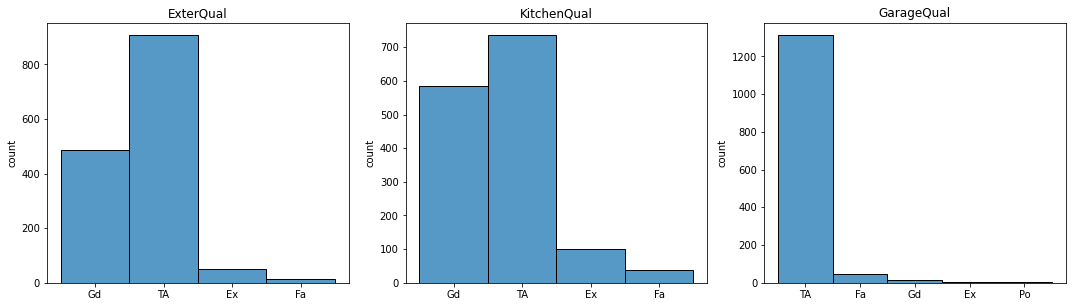

In [ ]:
# plot distributions for quality related data
fig_quality_ex = plt.figure(figsize = (15, 80))

for i, j in enumerate(quality_example):
    ax = fig_quality_ex.add_subplot(20, 3, i + 1)
    sns.histplot(data[j], ax = ax)
    plt.title(j)
    plt.xlabel(None)
    plt.ylabel('count')
    
fig_quality_ex.tight_layout()

In [ ]:
area_example = ['LotArea', 'GrLivArea', 'OpenPorchSF']

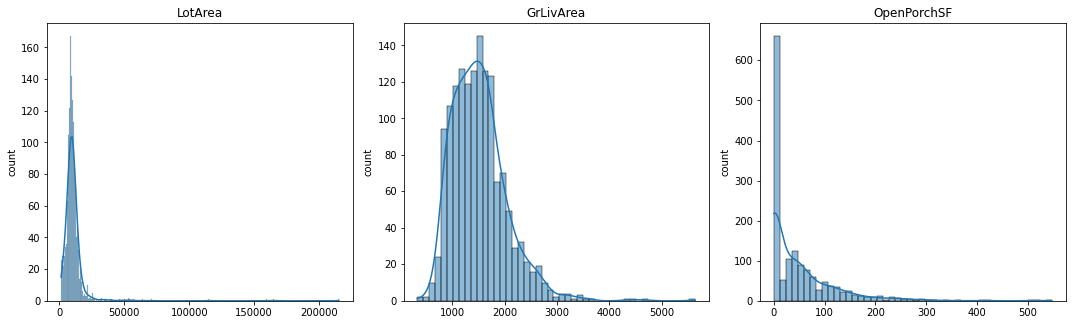

In [ ]:
# plot histograms for area related variables
fig_area_ex = plt.figure(figsize = (15, 85))

for i, j in enumerate(area_example):
    ax = fig_area_ex.add_subplot(20, 3, i + 1)
    sns.histplot(data[j], kde = True, ax = ax)
    plt.title(j)
    plt.xlabel(None)
    plt.ylabel('count')
    
fig_area_ex.tight_layout()

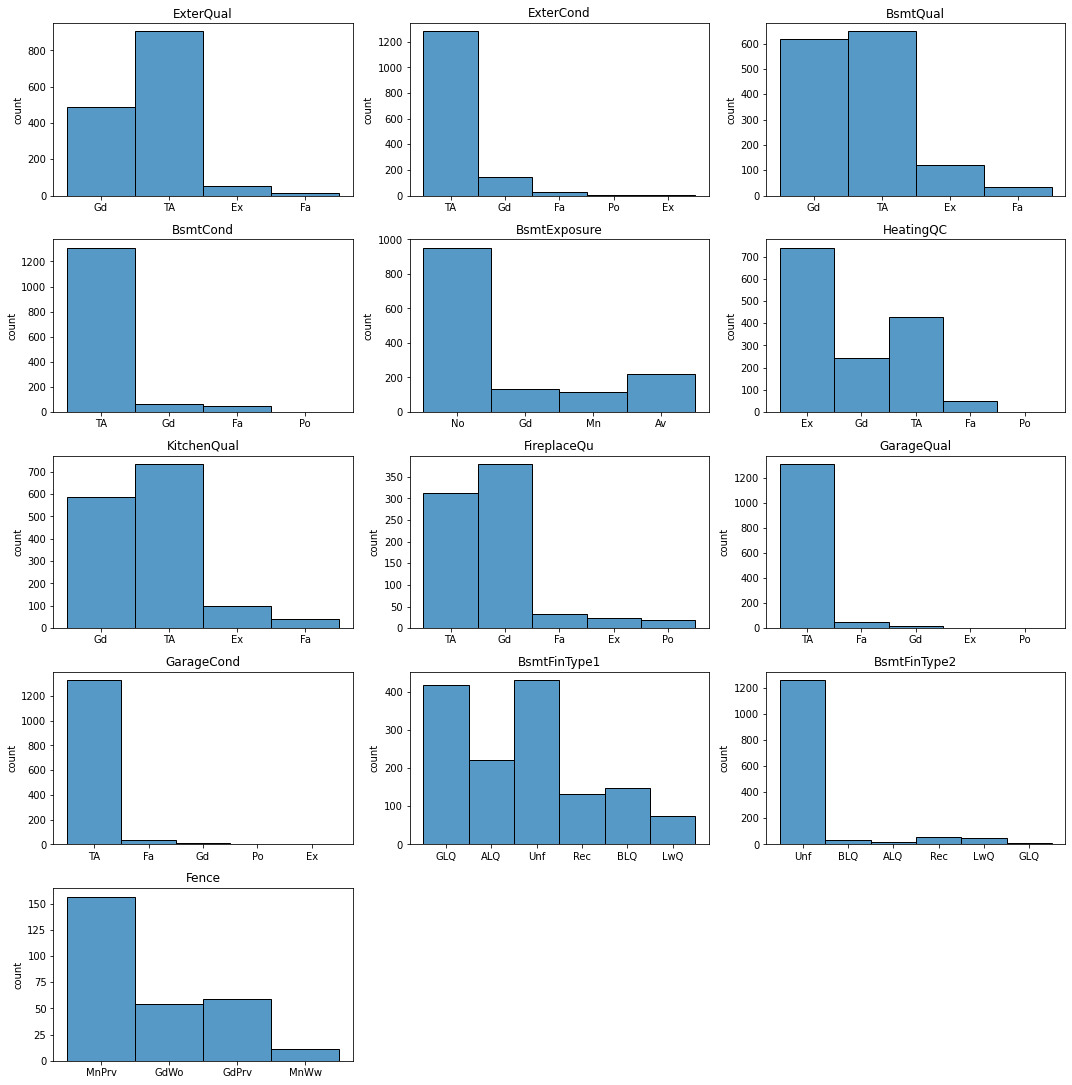

In [ ]:
# histograms for quality data (total)
fig_quality = plt.figure(figsize = (15, 60))

for i, j in enumerate(quality):
    ax = fig_quality.add_subplot(20, 3, i + 1)
    sns.histplot(data[j])
    plt.title(j)
    plt.xlabel(None)
    plt.ylabel('count')
    
fig_quality.tight_layout()

In [ ]:
area = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']

In [ ]:
print(np.shape(area))

(17,)


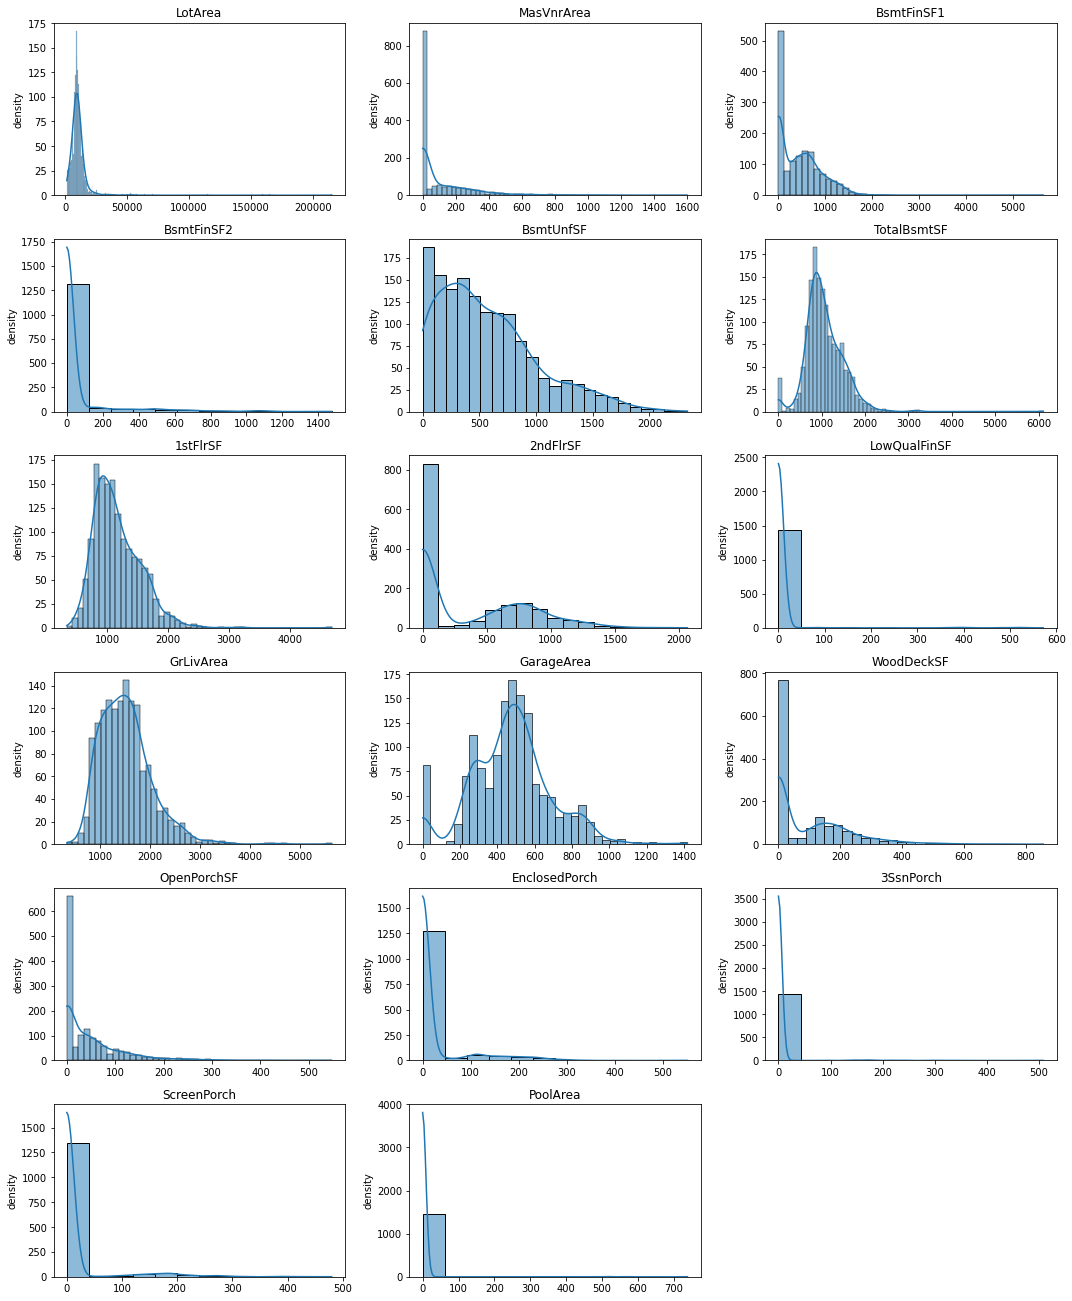

In [ ]:
# plot area related variables (total)
fig_area = plt.figure(figsize=(15, 60))

for i, j in enumerate(area):
    ax = fig_area.add_subplot(20, 3, i + 1)
    sns.histplot(data[j], kde = True, ax = ax)
    plt.title(j)
    plt.xlabel(None)
    plt.ylabel('density')
    
fig_area.tight_layout()

In [ ]:
categorical_1 = []
for i in categorical:
    if i not in area and i not in quality:
        categorical_1.append(i)

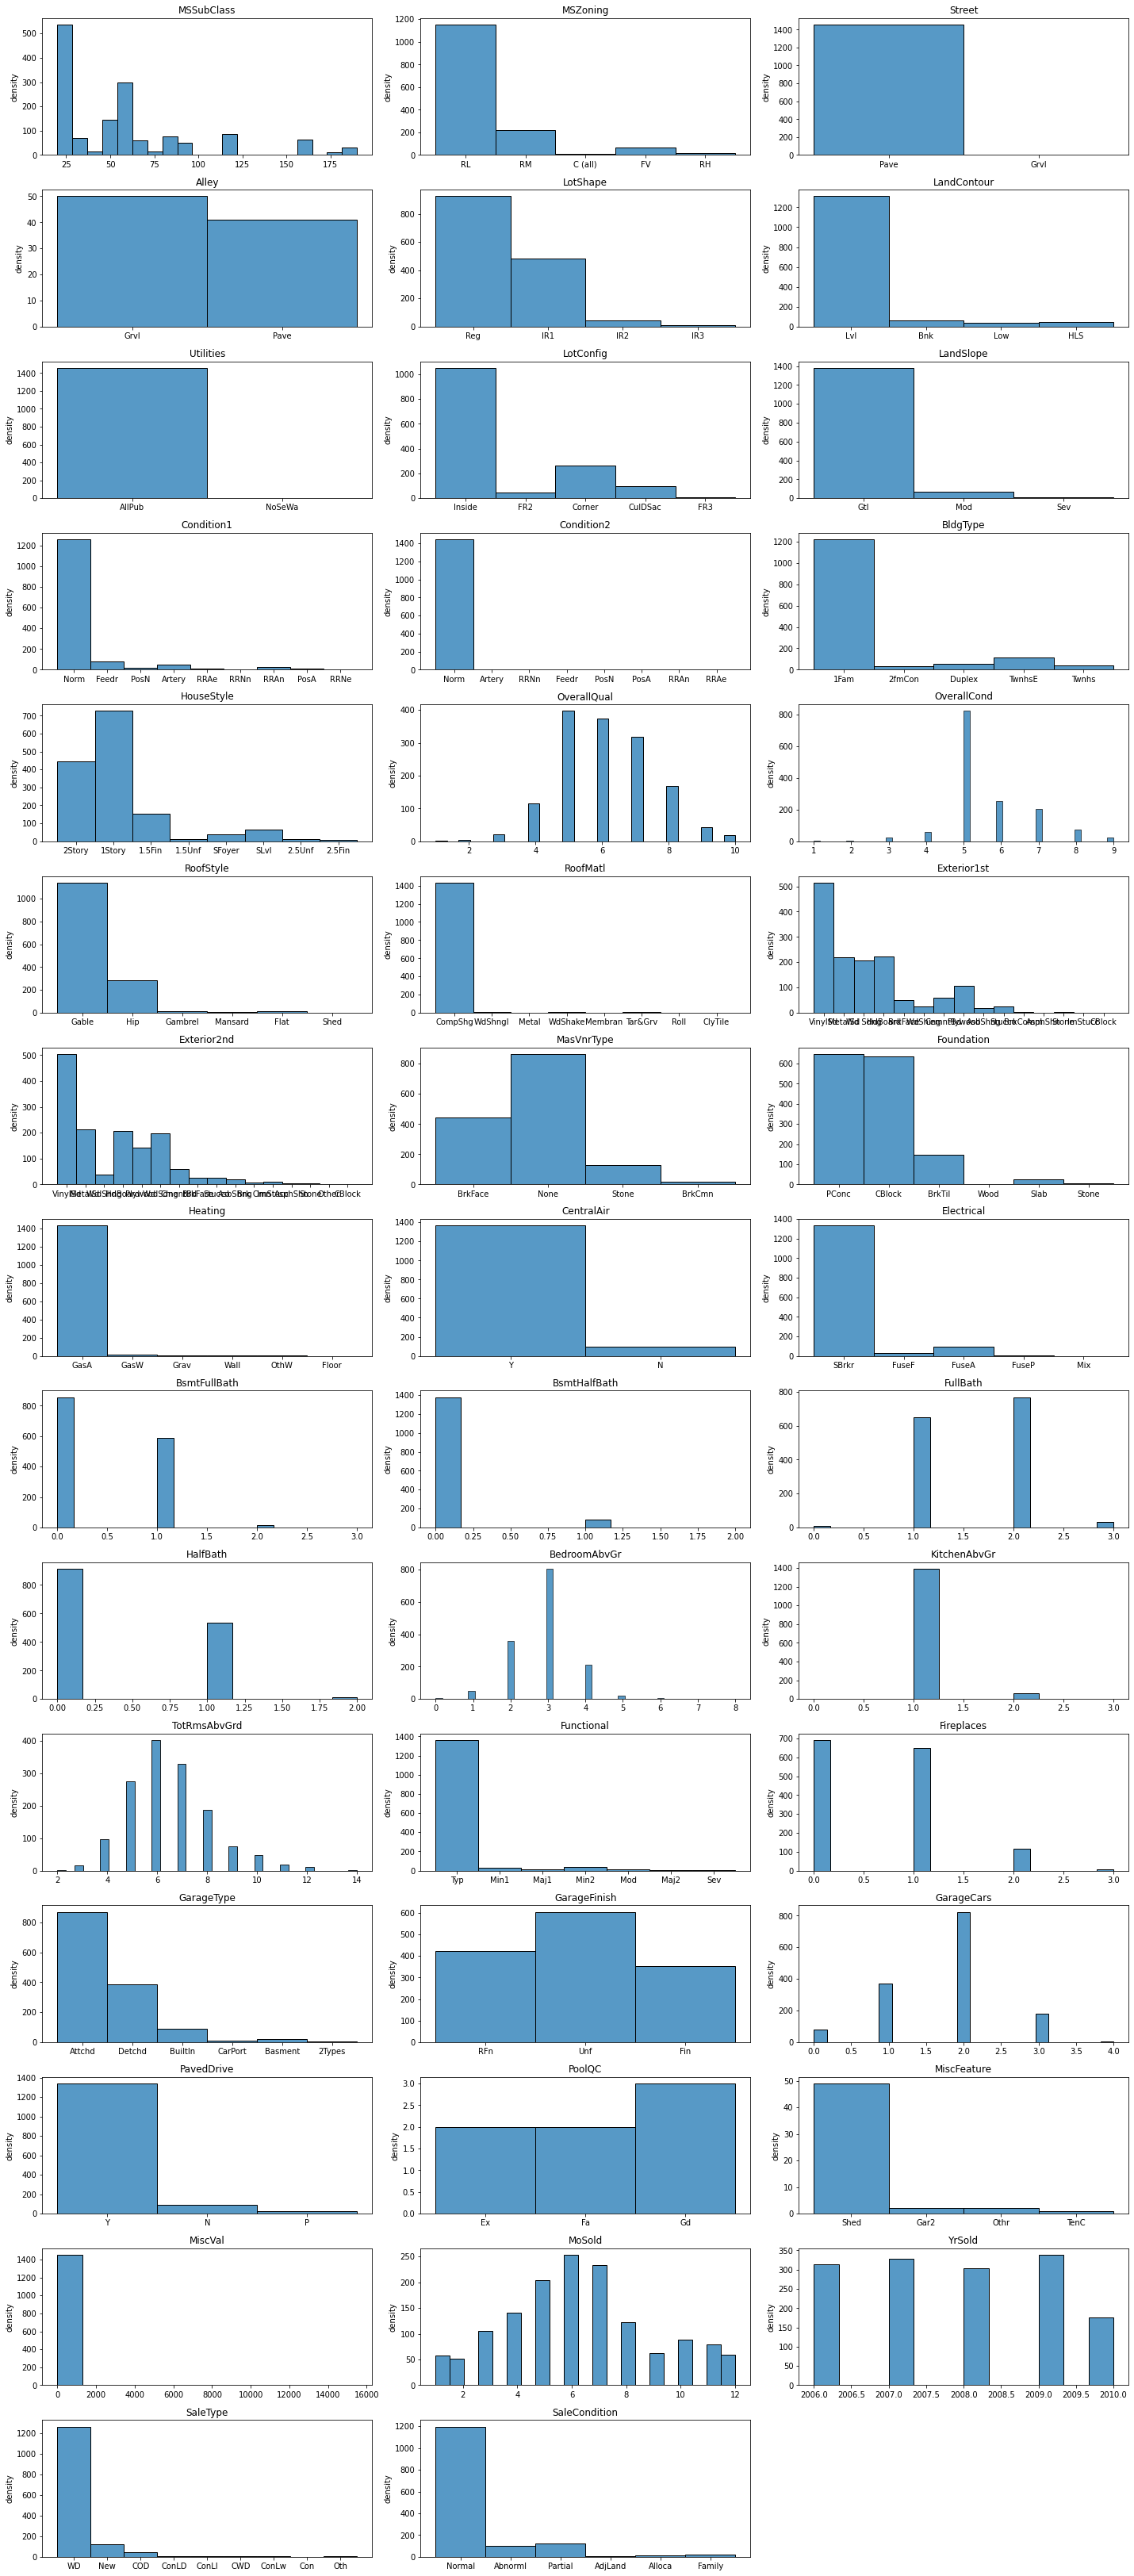

In [ ]:
# histograms for other categorical variables
fig_categorical_1 = plt.figure(figsize=(20, 60))

for i, j in enumerate(categorical_1):
    ax = fig_categorical_1.add_subplot(20, 3, i + 1)
    sns.histplot(data[j], kde = False, ax = ax)
    plt.title(j)
    plt.xlabel(None)
    plt.ylabel('density')
    
fig_categorical_1.tight_layout()

In [ ]:
numerical_1 = []
for i in numerical:
    if i not in area and i not in quality:
        numerical_1.append(i)
print(numerical_1)

['LotFrontage', 'Neighborhood', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'SalePrice']


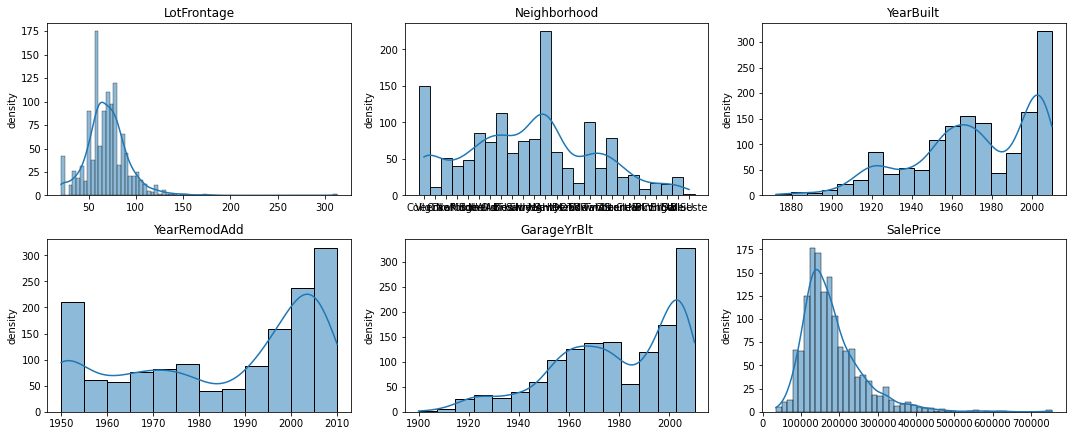

In [ ]:
# plot histograms for other numerical variables  
fig_numerical_1 = plt.figure(figsize=(15, 60))

for i, j in enumerate(numerical_1):
    ax = fig_numerical_1.add_subplot(20, 3, i + 1)
    sns.histplot(data[j], kde = True, ax = ax)
    plt.title(j)
    plt.xlabel(None)
    plt.ylabel('density')
    
fig_numerical_1.tight_layout()

### Data Transformation for Response Variable

In [ ]:
data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

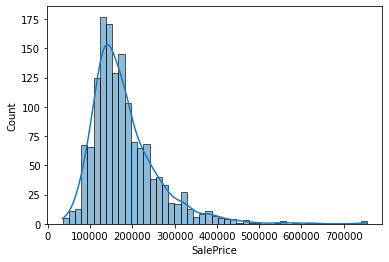

In [ ]:
# histgram for original sale price
sns.histplot(data['SalePrice'], kde = True)
plt.show()

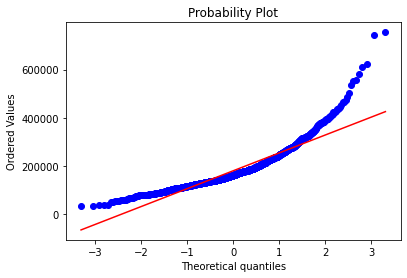

In [ ]:
# QQ plot for original sale price
fig_qq = plt.figure()
ans = stats.probplot(data['SalePrice'], plot = plt)
plt.show()

In [ ]:
# the distribution is not normal
# take log transformation on y
def log_transform(x):
    y = []
    for i in range(len(x)):
        ans = math.log(1 + x[i])
        y.append(ans)
    return y

log_y = log_transform(data['SalePrice'])

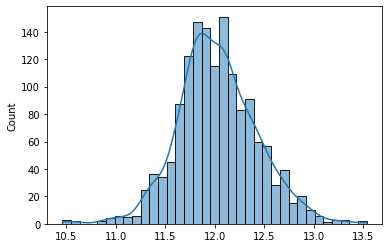

In [ ]:
# histogram of sale price after log transformation
sns.histplot(log_y, kde = True)
plt.show()

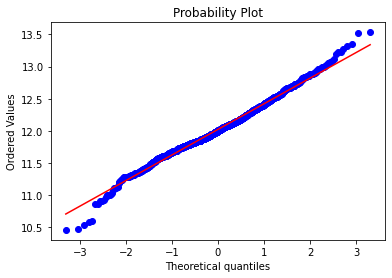

In [ ]:
# QQ plot of sale price after log transformation
fig_qq = plt.figure()
ans = stats.probplot(log_y, plot = plt)
plt.show()

In [ ]:
data['SalePrice'] = np.log1p(data['SalePrice'])

In [ ]:
saleprice = data['SalePrice']

In [ ]:
print(saleprice)

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64


### Missing Value Imputations

In [ ]:
all_data = data
all_data.drop(['SalePrice'], axis = 1, inplace = True)

In [ ]:
#find the variables with missing values and count the number of missing values
def find_missingdata(x):
    missing_data = []
    count_data = []
    for i in x.columns:
        null_count = x[i].isnull().sum()
        if null_count != 0:
            count_data.append(null_count)
            missing_data.append(i)
    return missing_data, count_data

missing_data, count_data = find_missingdata(all_data)

In [ ]:
print(missing_data, np.shape(missing_data))

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'] (19,)


In [ ]:
print(count_data, np.shape(count_data))

[259, 1369, 8, 8, 37, 37, 38, 37, 38, 1, 690, 81, 81, 81, 81, 81, 1453, 1179, 1406] (19,)


In [ ]:
# fill missing data with None and 0 
list_1 = ['MasVnrArea', 'GarageYrBlt']
for i in list_1:
    all_data[i] = all_data[i].fillna(0)
    
list_2 = ['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']
for j in list_2:
    all_data[j] = all_data[j].fillna('None')

In [ ]:
#fill missing data with the mode of variable
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [ ]:
#fill missing data with the median of variable
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [ ]:
#drop utilities
all_data = all_data.drop(['Utilities'], axis = 1)

In [ ]:
#check if there is missing data
print(all_data.isnull().sum().max())

0


In [ ]:
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

### Feature Encoding

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['MoSold'] = all_data['MoSold'].apply(str)
all_data['YrSold'] = all_data['YrSold'].apply(str)

In [ ]:
#Label-Encoder
group = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LotShape', 'LandSlope', 'PavedDrive', 'Street', 'Alley', 'MSSubClass', 'MoSold', 'YrSold', 'CentralAir', 'OverallCond']

for i in group:
    label = LabelEncoder()
    label.fit(list(all_data[i].values))
    all_data[i] = label.transform(list(all_data[i].values))
    
print(np.shape(all_data))

(1460, 78)


In [ ]:
features = list(all_data.columns)
print(features, np.shape(features))

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFea

In [ ]:
#find numerical variables
def find_numerical_features(data, features):
    
    num_features = list()
    
    for column in features:
        if data[column].dtypes != object: 
            num_features.append(column)
        else:
            continue
                
    return num_features

num_int = []
num_int = find_numerical_features(all_data, features)

In [ ]:
print(np.shape(num_int), num_int)

(58,) ['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscVal', 'MoSold', 'YrSold']


### Feature Standardization

In [ ]:
numerical_data = all_data[num_int]

#calculate skew
skew_data = numerical_data.apply(lambda x : skew(x.dropna())).sort_values(ascending = False)
skew_dataframe = pd.DataFrame({'skew': skew_data})
skew_dataframe.head()

,skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080


In [ ]:
#box-cox
lam = 0.10
for i in skew_dataframe.index:
    all_data[i] = boxcox1p(all_data[i], lam)

In [ ]:
#one-hot encoding
all_data = pd.get_dummies(all_data)
print(np.shape(all_data))

(1460, 220)


In [ ]:
print(np.shape(all_data))

(1460, 220)


## Model Fitting

---


### Fully Connected Neural Network

In [ ]:
all_data = pd.concat((all_data, saleprice), axis = 1)

In [ ]:
print(np.shape(all_data))

(1460, 221)


In [ ]:
#split all data into training data and testing data
data_train, data_test = train_test_split(all_data, test_size = 0.2)

In [ ]:
print(np.shape(data_train), np.shape(data_test))

(1168, 221) (292, 221)


In [ ]:
x_train = data_train.iloc[0:1168, 0:220]
y_train = data_train.iloc[0:1168, -1]
print(np.shape(x_train), np.shape(y_train))

(1168, 220) (1168,)


In [ ]:
#convert list to array
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
#convert array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).unsqueeze(1)

x_train = x_train.to(torch.float32)
y_train = y_train.to(torch.float32)

train_set = Data.TensorDataset(x_train, y_train)

#set batch-size is 50
train_data = DataLoader(dataset = train_set, batch_size = 50, shuffle = True)

In [ ]:
x_test = data_test.iloc[0:292, 0:220]
y_test = data_test.iloc[0:292, -1]

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test).unsqueeze(1)

x_test = x_test.to(torch.float32)
y_test = y_test.to(torch.float32)

test_set = Data.TensorDataset(x_test, y_test)

test_data = DataLoader(dataset = test_set, shuffle = False)

#### Single Layer Model

In [ ]:
# initialization parameters

input_num = 220
#the number of node of hidden layer
hidden_num = 128
#the dim of output
class_num = 1
#learning rate
learning_rate = 0.001
#the number of iteration
epochs_num = 80

In [ ]:
#build fully connected neural network

class neural_network(nn.Module):
    
    def __init__(self, input_num, hidden_num, class_num):
        super(neural_network, self).__init__()
        self.f1 = nn.Linear(input_num, hidden_num) 
        self.f2 = nn.Linear(hidden_num, class_num)
        #set activation function
        self.active = nn.ReLU()
        
    def forward(self, x):
        x = self.f1(x)
        x = self.active(x)
        x = self.f2(x)
        return x

In [ ]:
model = neural_network(input_num, hidden_num, class_num)

In [ ]:
#calculate mse and mae
def eval_calculate(target, prediction):
    #r2_score = metrics.r2_score(target, prediction)
    mae = metrics.mean_absolute_error(target, prediction)
    mse = metrics.mean_squared_error(target, prediction)
    
    return mae, mse

In [ ]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
losses = []
mse = []
list_mse, list_mae = [], []

for i in range(epochs_num):
    train_loss = 0
    for tdata, tlabel in train_data:
        pred = model(tdata)
        loss = loss_function(pred, tlabel)
    
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
        
    losses.append(train_loss / len(train_data))
    mse.append(train_loss)
    
    #calculate mse and mae of the test data
    if i % 2 == 0:
        test_mse = []
        test_mae = []
        #test_r2 = []
        
        for data, target in test_data:
            predict = model(data)
            target, predict = target.detach(), predict.detach()
            
            mae_test, mse_test = eval_calculate(target, predict)
            
            #test_r2.append(r2_score)
            test_mse.append(mse_test)
            test_mae.append(mae_test)
            
        mse_p = torch.mean(torch.tensor(test_mse))
        mae_p = torch.mean(torch.tensor(test_mae))
        #r2_p = torch.mean(torch.tensor(test_r2))
        
        list_mse.append(mse_p)
        list_mae.append(mae_p)
        #list_r2.append(r2_p)
        print(mse_p, mae_p)

tensor(6.6656) tensor(2.4325)
tensor(0.4451) tensor(0.4913)
tensor(0.2639) tensor(0.3630)
tensor(0.1410) tensor(0.2701)
tensor(0.0910) tensor(0.2238)
tensor(0.0699) tensor(0.2006)
tensor(0.0551) tensor(0.1745)
tensor(0.0489) tensor(0.1644)
tensor(0.0447) tensor(0.1567)
tensor(0.0405) tensor(0.1485)
tensor(0.0377) tensor(0.1437)
tensor(0.0360) tensor(0.1397)
tensor(0.0338) tensor(0.1357)
tensor(0.0323) tensor(0.1318)
tensor(0.0307) tensor(0.1276)
tensor(0.0304) tensor(0.1281)
tensor(0.0285) tensor(0.1243)
tensor(0.0285) tensor(0.1259)
tensor(0.0301) tensor(0.1303)
tensor(0.0279) tensor(0.1240)
tensor(0.0259) tensor(0.1172)
tensor(0.0265) tensor(0.1184)
tensor(0.0251) tensor(0.1162)
tensor(0.0238) tensor(0.1121)
tensor(0.0237) tensor(0.1110)
tensor(0.0244) tensor(0.1129)
tensor(0.0230) tensor(0.1101)
tensor(0.0227) tensor(0.1088)
tensor(0.0219) tensor(0.1066)
tensor(0.0219) tensor(0.1049)
tensor(0.0223) tensor(0.1057)
tensor(0.0211) tensor(0.1048)
tensor(0.0217) tensor(0.1073)
tensor(0.0

In [ ]:
print(np.shape(losses), np.shape(mse))

(80,) (80,)


In [ ]:
print(list_mae, list_mse)

[tensor(2.4325), tensor(0.4913), tensor(0.3630), tensor(0.2701), tensor(0.2238), tensor(0.2006), tensor(0.1745), tensor(0.1644), tensor(0.1567), tensor(0.1485), tensor(0.1437), tensor(0.1397), tensor(0.1357), tensor(0.1318), tensor(0.1276), tensor(0.1281), tensor(0.1243), tensor(0.1259), tensor(0.1303), tensor(0.1240), tensor(0.1172), tensor(0.1184), tensor(0.1162), tensor(0.1121), tensor(0.1110), tensor(0.1129), tensor(0.1101), tensor(0.1088), tensor(0.1066), tensor(0.1049), tensor(0.1057), tensor(0.1048), tensor(0.1073), tensor(0.1017), tensor(0.1006), tensor(0.0993), tensor(0.1031), tensor(0.0978), tensor(0.1011), tensor(0.1020)] [tensor(6.6656), tensor(0.4451), tensor(0.2639), tensor(0.1410), tensor(0.0910), tensor(0.0699), tensor(0.0551), tensor(0.0489), tensor(0.0447), tensor(0.0405), tensor(0.0377), tensor(0.0360), tensor(0.0338), tensor(0.0323), tensor(0.0307), tensor(0.0304), tensor(0.0285), tensor(0.0285), tensor(0.0301), tensor(0.0279), tensor(0.0259), tensor(0.0265), tensor

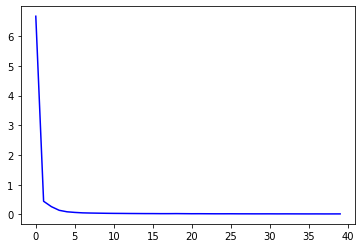

In [ ]:
#mse of testing data
plt.plot(list_mse, color = 'blue')
plt.show()

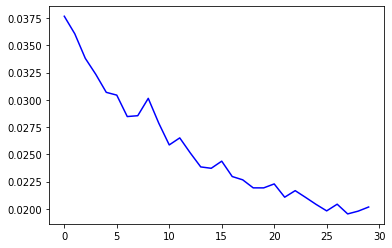

In [ ]:
#mae of testing data
plt.plot(list_mse[10:40], color = 'blue')
plt.show()

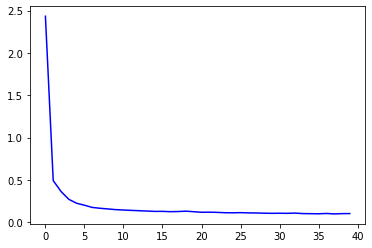

In [ ]:
#mae of testing data
plt.plot(list_mae, color = 'blue')
plt.show()

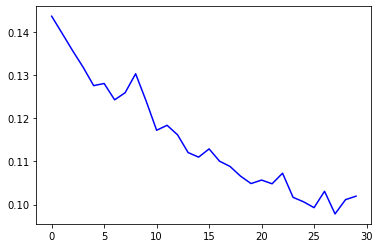

In [ ]:
# sample of mse for 10-40 epochs
plt.plot(list_mae[10:40], color = 'blue')
plt.show()

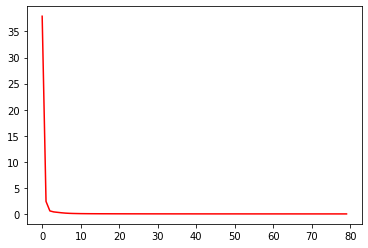

In [ ]:
# mse of trainning data
plt.plot(losses, color = 'red')
plt.show()

#### Two-layer Model

In [ ]:
input_num = 220
#the number of node of hidden layer
hidden_num_1 = 128
hidden_num_2 = 32
#the dim of output
class_num = 1
#learning rate
learning_rate = 0.001
#the number of iteration
epochs_num = 80

In [ ]:
class neural_network_1(nn.Module):
    
    def __init__(self, input_num, hidden_num_1, hidden_num_2, class_num):
        super(neural_network_1, self).__init__()
        self.f1 = nn.Linear(input_num, hidden_num_1)
        self.f3 = nn.Linear(hidden_num_1, hidden_num_2)
        self.f2 = nn.Linear(hidden_num_2, class_num)
        self.active = nn.ReLU()
        
    def forward(self, x):
        x = self.f1(x)
        x = self.active(x)
        x = self.f2(x)
        x = self.active(x)
        x = self.f3(x)
        return x

In [ ]:
model_1 = neural_network_1(input_num, hidden_num_1, hidden_num_2, class_num)

In [ ]:
loss_function_1 = torch.nn.MSELoss()
optimizer_1 = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
# obtain losses, mse, and mae for 2-layer model
losses_1 = []
mse_1 = []
list_mse_1, list_mae_1 = [], []

for i in range(epochs_num):
    train_loss = 0
    for tdata, tlabel in train_data:
        pred = model(tdata)
        loss = loss_function_1(pred, tlabel)
    
        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()
        train_loss = train_loss + loss.item()
        
    losses_1.append(train_loss / len(train_data))
    mse_1.append(train_loss)
    
    if i % 2 == 0:
        test_mse_1 = []
        test_mae_1 = []
        
        for data, target in test_data:
            predict = model(data)
            target, predict = target.detach(), predict.detach()
            
            mae_test, mse_test = eval_calculate(target, predict)
            
            test_mse_1.append(mse_test)
            test_mae_1.append(mae_test)
            
        mse_p_1 = torch.mean(torch.tensor(test_mse_1))
        mae_p_1 = torch.mean(torch.tensor(test_mae_1))
        
        list_mse_1.append(mse_p_1)
        list_mae_1.append(mae_p_1)
        
        print(mse_p_1, mae_p_1)

tensor(0.0239) tensor(0.1113)
tensor(0.0205) tensor(0.0994)
tensor(0.0201) tensor(0.1031)
tensor(0.0181) tensor(0.0941)
tensor(0.0223) tensor(0.1087)
tensor(0.0186) tensor(0.0950)
tensor(0.0186) tensor(0.0968)
tensor(0.0194) tensor(0.0989)
tensor(0.0223) tensor(0.1103)
tensor(0.0242) tensor(0.1188)
tensor(0.0222) tensor(0.1121)
tensor(0.0238) tensor(0.1184)
tensor(0.0186) tensor(0.0974)
tensor(0.0176) tensor(0.0941)
tensor(0.0176) tensor(0.0934)
tensor(0.0242) tensor(0.1212)
tensor(0.0176) tensor(0.0935)
tensor(0.0177) tensor(0.0959)
tensor(0.0162) tensor(0.0891)
tensor(0.0170) tensor(0.0923)
tensor(0.0174) tensor(0.0945)
tensor(0.0175) tensor(0.0979)
tensor(0.0212) tensor(0.1109)
tensor(0.0175) tensor(0.0936)
tensor(0.0156) tensor(0.0888)
tensor(0.0173) tensor(0.0923)
tensor(0.0218) tensor(0.1149)
tensor(0.0159) tensor(0.0874)
tensor(0.0167) tensor(0.0900)
tensor(0.0296) tensor(0.1359)
tensor(0.0194) tensor(0.1047)
tensor(0.0177) tensor(0.0926)
tensor(0.0187) tensor(0.0994)
tensor(0.0

In [ ]:
print(losses_1)

[0.11744513246230781, 0.02013566019013524, 0.01485000061802566, 0.013825872738379985, 0.015294328254337112, 0.014317840803414583, 0.015188049602632722, 0.012836563575547189, 0.013121479734157523, 0.016027878601259243, 0.01588987479529654, 0.012707543093711138, 0.015134784276597202, 0.0130361847501869, 0.014005361163678268, 0.013770504602386305, 0.012923980015330017, 0.013499082434767237, 0.013625812386938682, 0.015817553464633722, 0.013807799414886782, 0.01255772024160251, 0.01424036625151833, 0.013376782182604074, 0.011109769848796228, 0.01163972431095317, 0.0150418032038336, 0.01271836347101877, 0.012908495923814675, 0.011743011826183647, 0.012536653026472777, 0.015558130340650678, 0.011972239648457617, 0.01224998376953105, 0.012740536845133951, 0.010486714716535062, 0.01077524460076044, 0.010241482445659736, 0.00992613413836807, 0.00976075070987766, 0.010307715875872722, 0.012743710171586523, 0.013915504425919304, 0.01527112047187984, 0.01160355139290914, 0.009534942529474696, 0.011

In [ ]:
print(mse_1)

[2.8186831790953875, 0.4832558445632458, 0.35640001483261585, 0.33182094572111964, 0.3670638781040907, 0.34362817928195, 0.3645131904631853, 0.3080775258131325, 0.31491551361978054, 0.3846690864302218, 0.38135699508711696, 0.3049810342490673, 0.36323482263833284, 0.3128684340044856, 0.33612866792827845, 0.33049211045727134, 0.3101755203679204, 0.32397797843441367, 0.32701949728652835, 0.37962128315120935, 0.3313871859572828, 0.30138528579846025, 0.3417687900364399, 0.3210427723824978, 0.2666344763711095, 0.2793533834628761, 0.3610032768920064, 0.3052407233044505, 0.3098039021715522, 0.2818322838284075, 0.30087967263534665, 0.37339512817561626, 0.2873337515629828, 0.29399961046874523, 0.3057728842832148, 0.2516811531968415, 0.25860587041825056, 0.24579557869583368, 0.23822721932083368, 0.23425801703706384, 0.2473851810209453, 0.30584904411807656, 0.3339721062220633, 0.36650689132511616, 0.27848523342981935, 0.2288386207073927, 0.28464884404093027, 0.26347533892840147, 0.2654758202843368

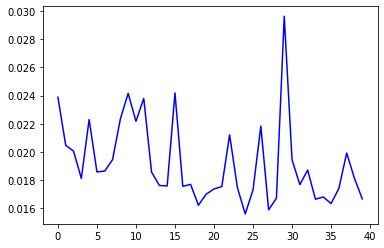

In [ ]:
# mse plot for 2_layer
plt.plot(list_mse_1, color = 'blue')
plt.show()

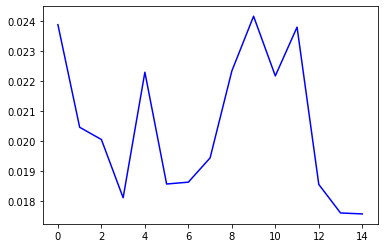

In [ ]:
plt.plot(list_mse_1[0:15], color = 'blue')
plt.show()

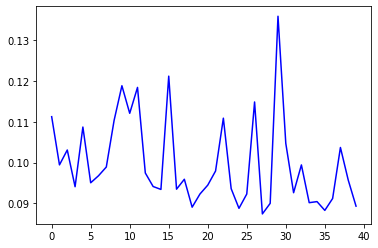

In [ ]:
plt.plot(list_mae_1, color = 'blue')
plt.show()

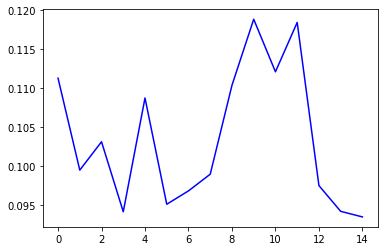

In [ ]:
plt.plot(list_mae_1[0:15], color = 'blue')
plt.show()

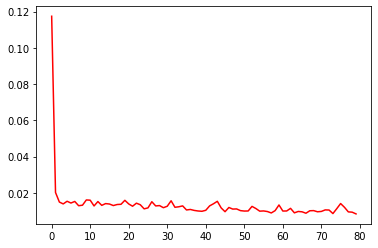

In [ ]:
# losses plot for training
plt.plot(losses_1, color = 'red')
plt.show()

#### Multiple Linear Regression

In [ ]:
|#linear regression
reg = linear_model.LinearRegression()
reg = reg.fit(x_train, y_train)
coef_1 = reg.coef_
print(np.shape(coef_1))

(220,)


In [ ]:
x_test = data_test.iloc[0:292, 0:220]
y_test = data_test.iloc[0:292, -1]

In [ ]:
#make prediction
predict = x_test @ coef_1
predict = predict.values

#calculate r^2
accuracy_score = explained_variance_score(y_test, predict)
print(accuracy_score)

0.8866680875631252


In [ ]:
#calculate mse
mean_squared_error(y_test, predict)

420.53791335750367

### LASSO Regression

In [ ]:
# build lasso regresser
lasso = linear_model.Lasso(alpha=0.1)

In [ ]:
# fit lasso on train data
lasso = lasso.fit(x_train, y_train)
coef_2 = lasso.coef_
print(np.shape(coef_2))

(220,)


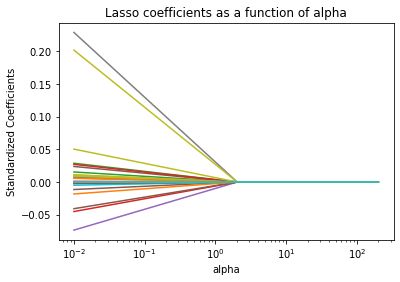

In [ ]:
# plot the lasso coefficients
alphas = np.linspace(0.01,200,100)

coefs = []

for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(x_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

In [ ]:
#make prediction
predict_lasso = x_test @ coef_2
predict_lasso = predict_lasso.values

#calculate r^2
accuracy_score_lasso = explained_variance_score(y_test, predict_lasso)
print(accuracy_score_lasso)

0.505613375064036


In [ ]:
#calculate mse
mean_squared_error(y_test, predict_lasso)

118.74148179912974

### Random Forest

In [ ]:
# fit random forest on train data
rf_clf = RandomForestRegressor(n_estimators=1, max_features=100, max_depth=20)
rf_clf.fit(x_train, y_train)
predict_rf = rf_clf.predict(x_test)

In [ ]:
#calculate r^2
accuracy_score_rf = explained_variance_score(y_test, predict_rf)
print(accuracy_score_rf)

0.6838321542806273


In [ ]:
#calculate mse
mean_squared_error(y_test, predict_rf)

0.0573378884452755